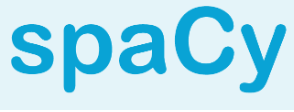

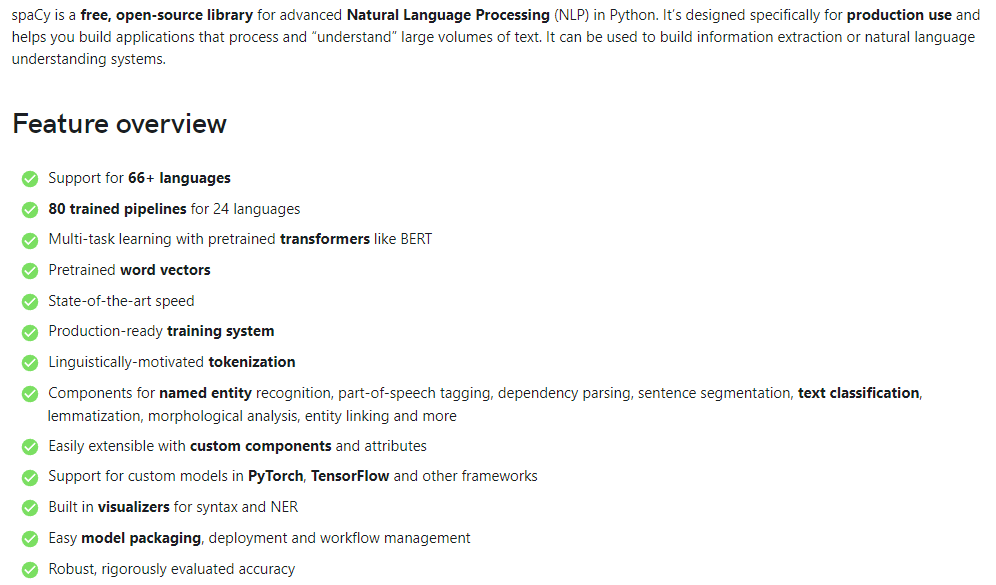

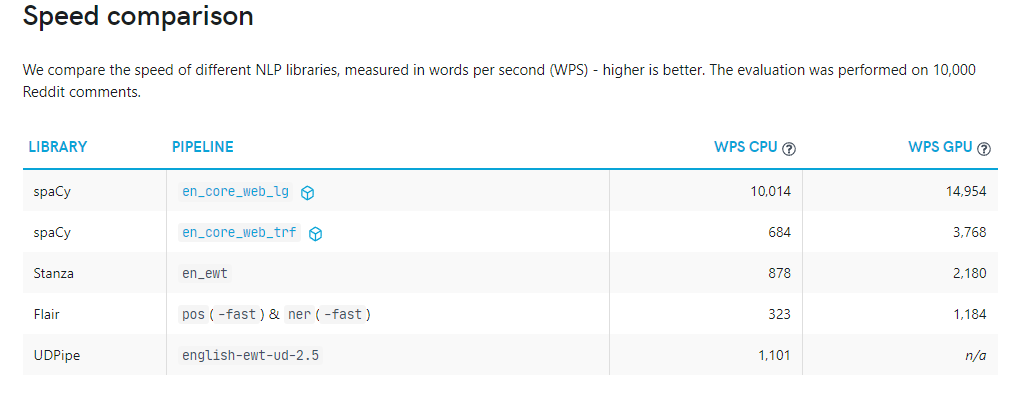

## [Architecture](https://spacy.io/usage/spacy-101#architecture)

The central data structures in spaCy are the `[Language](https://spacy.io/api/language)` class, the `[Vocab](https://spacy.io/api/vocab)` and the `[Doc](https://spacy.io/api/doc)` object. The `Language` class is used to process a text and turn it into a `Doc` object. It’s typically stored as a variable called `nlp`. The `Doc` object owns the **sequence of tokens** and all their annotations. By centralizing strings, word vectors and lexical attributes in the `Vocab`, we avoid storing multiple copies of this data. This saves memory, and ensures there’s a **single source of truth**.

Text annotations are also designed to allow a single source of truth: the `Doc` object owns the data, and `[Span](https://spacy.io/api/span)` and `[Token](https://spacy.io/api/token)` are **views that point into it**. The `Doc` object is constructed by the `[Tokenizer](https://spacy.io/api/tokenizer)`, and then **modified in place** by the components of the pipeline. The `Language` object coordinates these components. It takes raw text and sends it through the pipeline, returning an **annotated document**. It also orchestrates training and serialization.

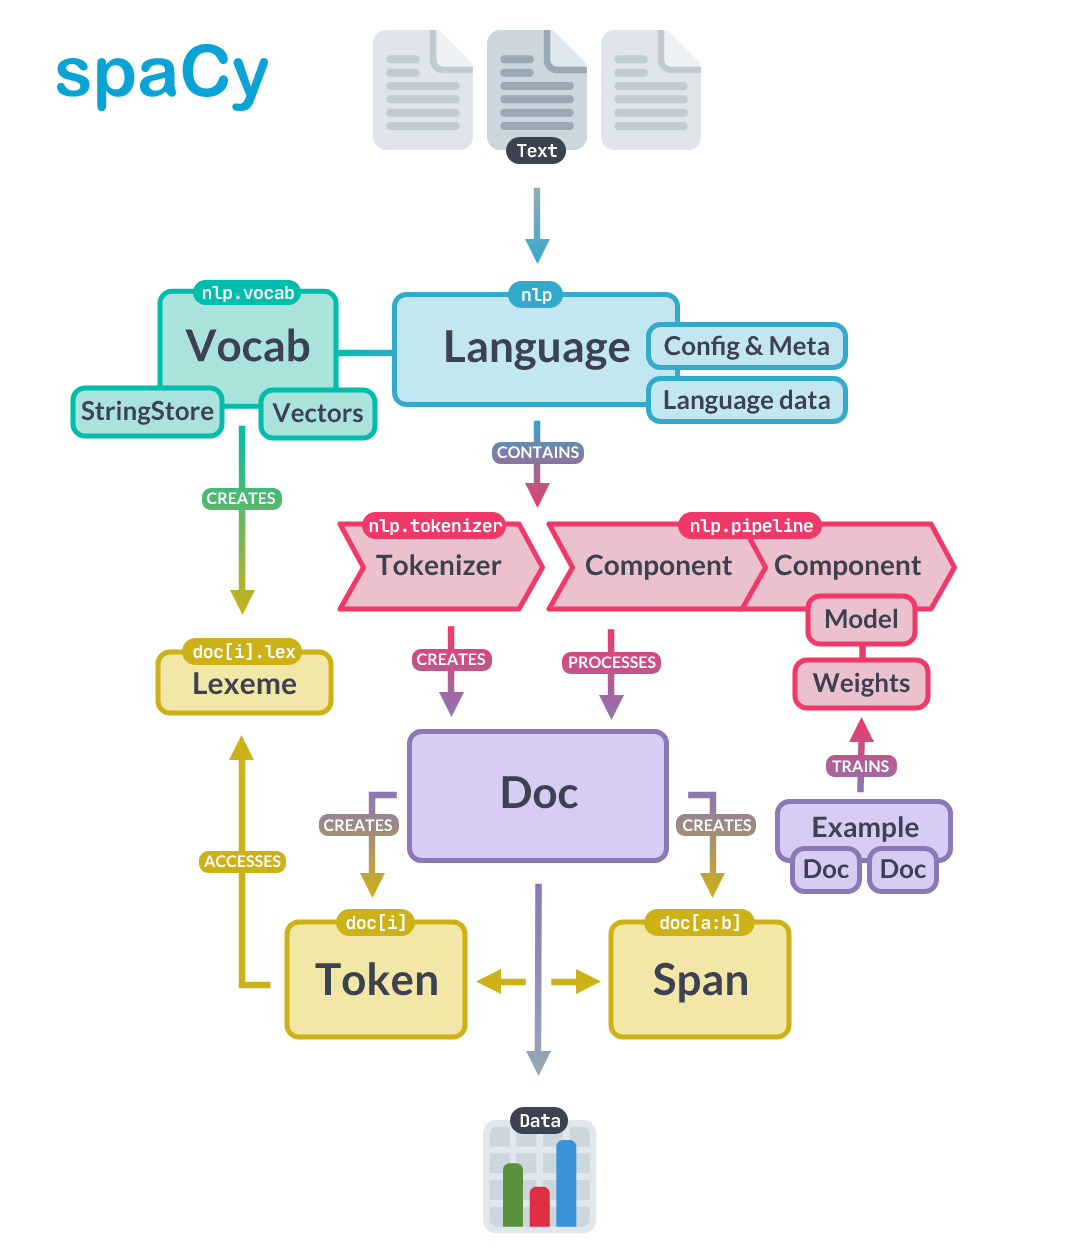

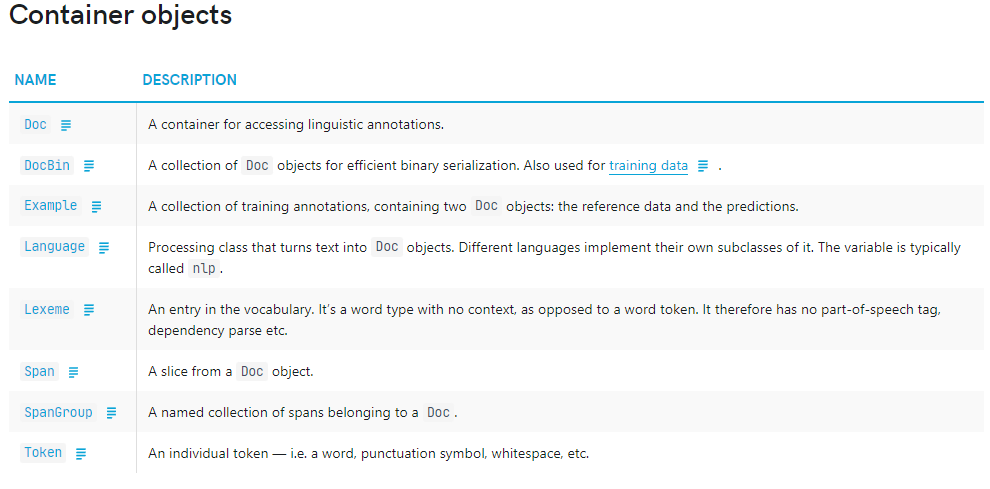

### [Trainable components](https://spacy.io/usage/spacy-101#training-components)

spaCy’s `[Pipe](https://spacy.io/api/pipe)` class helps you implement your own trainable components that have their own model instance, make predictions over `Doc` objects and can be updated using `[spacy train](https://spacy.io/api/cli#train)`. This lets you plug fully custom machine learning components into your pipeline that can be configured via a single training config.

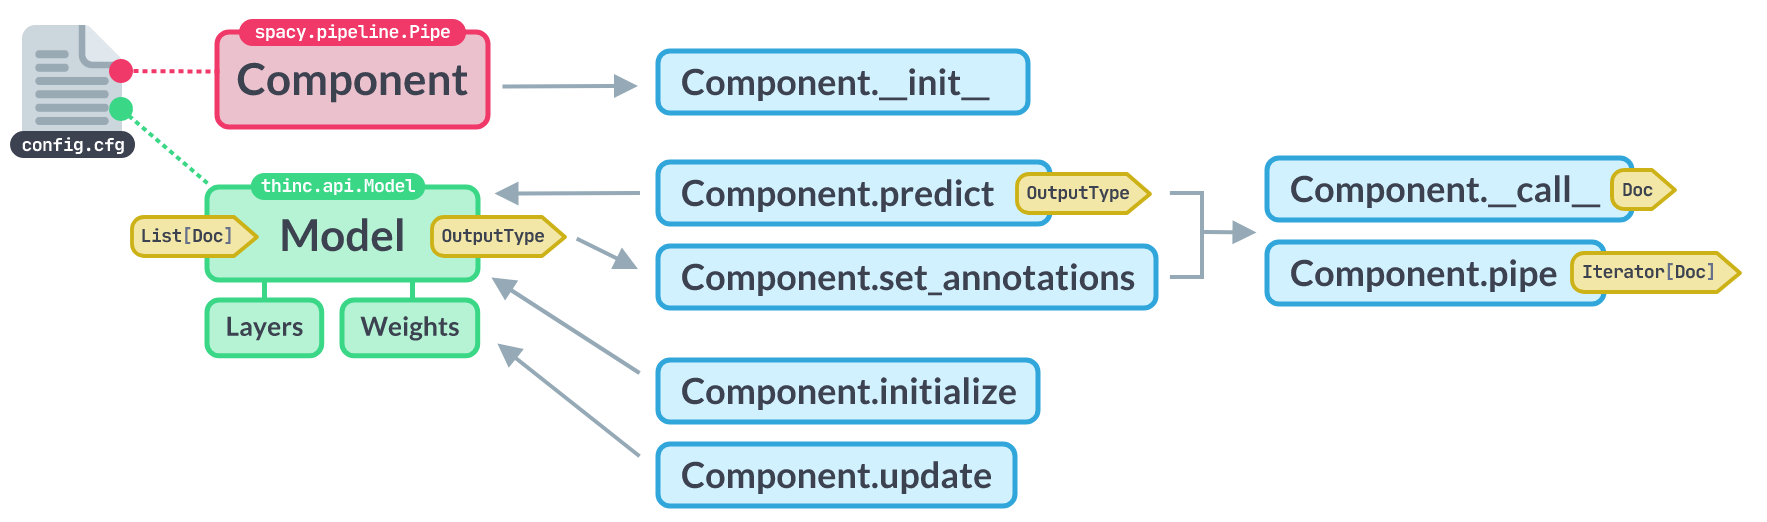

### [Metrics, training output and weighted scores](https://spacy.io/usage/training#metrics)

When you train a pipeline using the `[spacy train](https://spacy.io/api/cli#train)` command, you’ll see a table showing the metrics after each pass over the data. The available metrics **depend on the pipeline components**. Pipeline components also define which scores are shown and how they should be **weighted in the final score** that decides about the best model.

The `training.score_weights` setting in your `config.cfg` lets you customize the scores shown in the table and how they should be weighted. In this example, the labeled dependency accuracy and NER F-score count towards the final score with 40% each and the tagging accuracy makes up the remaining 20%. The tokenization accuracy and speed are both shown in the table, but not counted towards the score.

[training.score_weights]
dep_las = 0.4,
dep_uas = null,
ents_f = 0.4,
tag_acc = 0.2,
token_acc = 0.0,
speed = 0.0,

The `score_weights` don’t *have to* sum to `1.0` – but it’s recommended. When you generate a config for a given pipeline, the score weights are generated by combining and normalizing the default score weights of the pipeline components. The default score weights are defined by each pipeline component via the `default_score_weights` setting on the `[@Language.factory](https://spacy.io/api/language#factory)` decorator. By default, all pipeline components are weighted equally. If a score weight is set to `null`, it will be excluded from the logs and the score won’t be weighted.

### Understanding the training output and score types[¶](https://spacy.io/usage/training#score-types)

Note that if the development data has raw text, some of the gold-standard entities might not align to the predicted tokenization. These tokenization errors are **excluded from the NER evaluation**. If your tokenization makes it impossible for the model to predict 50% of your entities, your NER F-score might still look good.

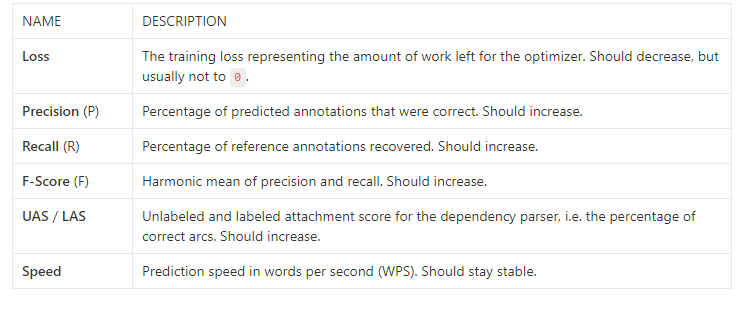

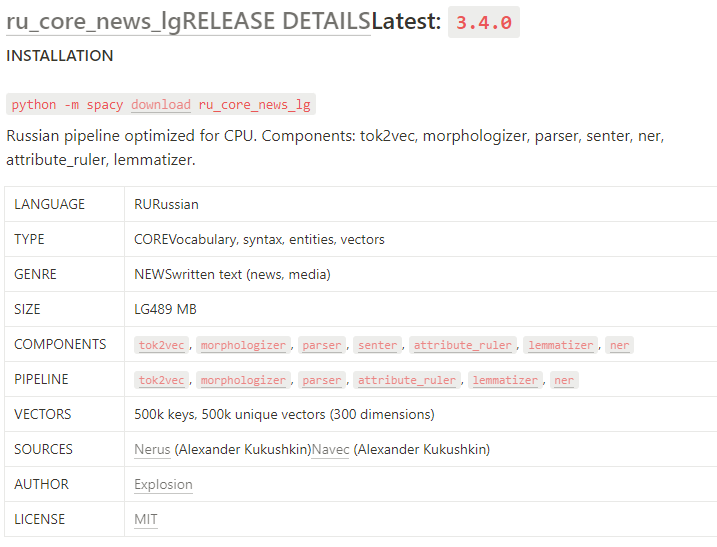

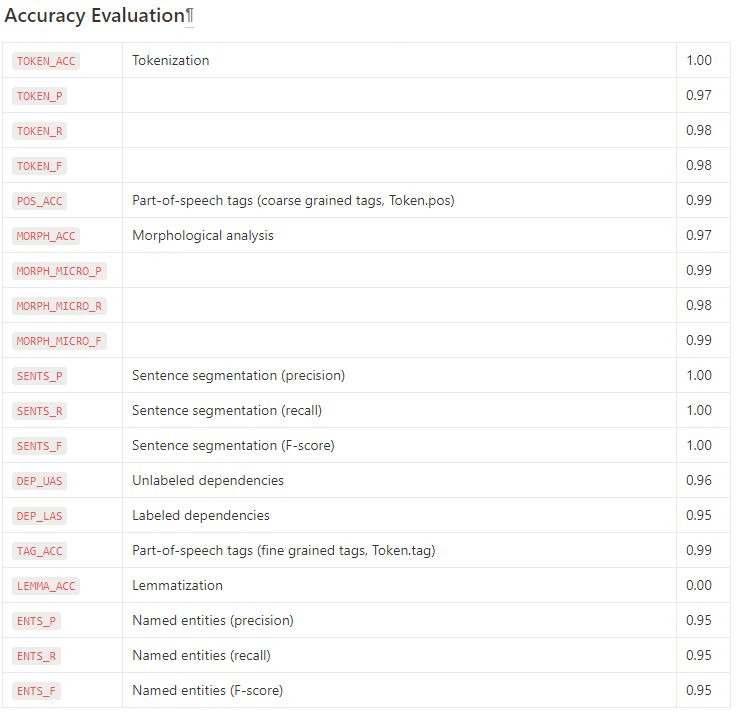

[**https://spacy.io/api/data-formats#config**](https://spacy.io/api/data-formats#config)

**Exemple of Train spacy with Natasha [https://github.com/natasha/natasha-spacy](https://github.com/natasha/natasha-spacy) (pipeline = ["tagger","parser","ner"])  with that Datasets** [https://github.com/natasha/nerus](https://github.com/natasha/nerus) ,  [https://github.com/natasha/navec](https://github.com/natasha/navec)

**Exemple train dataset how looks** [https://github.com/buriy/spacy-ru/blob/master/notebooks/corpora/kaggle_ru.ipynb](https://github.com/buriy/spacy-ru/blob/master/notebooks/corpora/kaggle_ru.ipynb)

**How learn** [https://habr.com/ru/post/571950/](https://habr.com/ru/post/571950/)

**Create config** [https://spacy.io/usage/training](https://spacy.io/usage/training)

**For training in Colab** [https://towardsdatascience.com/how-to-fine-tune-bert-transformer-with-spacy-3-6a90bfe57647](https://towardsdatascience.com/how-to-fine-tune-bert-transformer-with-spacy-3-6a90bfe57647)

## Формирование сэмпла новостей для сравнения ##

Берем сэмпл из 30 новостей, взятых из файла экспорта телеграм канало РИА Новости (с 01.06.2022 по 09.10.2022)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import re
import pandas as pd
import spacy
from spacy.matcher import Matcher 
from spacy.tokens import Span 

In [2]:
df = pd.read_json('tg_chatexport__rian_ru__20220601-20221009.json')
df = df['messages'].apply(pd.Series)

In [3]:
df = df[((df.mime_type.isnull()) & 
                   (df.reply_to_message_id.isnull()) & 
                   (df.text.map(type) == str) &
                   (df.text != ''))]
df = df[["date", "text"]]

In [4]:
sample_index = [10310, 10393,  8861, 13481, 13926,  1438,  8554,  9460,  6249,
             1893, 14808,  7680,  3214,   720, 15226,   887, 13284,  3291,
             5576, 14154, 10615,  7154, 12205, 12156,  2070,   796,  4772,
            14467,  1404,  2666]
df = df.loc[sample_index]
print('\n--------------------\n'.join(df.text.to_list()))

Китай остановил импорт мясной продукции американской Tyson Fresh Meat – одной из крупнейших продовольственных компаний в мире. Причиной названо несоответствие китайским стандартам качества.
--------------------
Почти половина коррупции в России приходится на два федеральных округа: Приволжье (24,2%) и центральную Россию (21,5%), следует из данных Генпрокуратуры за 7 месяцев.

Далее Юг (14,6%), Сибирь (10,5%), Северный Кавказ (8,8%), Урал (тоже 8,8%), Северо-Запад (6,4%) и Дальний Восток (5,3%).
--------------------
Гендиректором "Победы" назначен бывший первый замгендиректора "Авроры" Тыщук
--------------------
Урожай зерновых в России в 2022 может составить рекордные 142 млн тонн, сохраняются все поставки продовольствия в дружественные страны, даже наращиваются в ряд недружественных, рассказала вице-премьер Абрамченко
--------------------
Победители конкурса имени Андрея Стенина за 2022 объявлены в Москве, среди них конкурсанты из Гватемалы, Индии, Бангладеш, Ирана, Италии.

В номинац

## Проверка функционала spaCy

https://spacy.io/usage

Предобученных на русском языке 2 модели - 'ru_core_news_sm' (efficiency - faster and smaller pipeline, but less accurate) и 'ru_core_news_lg' (accuracy - larger and slower pipeline, but more accurate)

In [5]:
df.iloc[0].text

'Китай остановил импорт мясной продукции американской Tyson Fresh Meat – одной из крупнейших продовольственных компаний в мире. Причиной названо несоответствие китайским стандартам качества.'

In [6]:
df

,date,text
10310,2022-08-29T16:17:46,Китай остановил импорт мясной продукции америк...
10393,2022-08-30T11:56:41,Почти половина коррупции в России приходится н...
8861,2022-08-15T11:30:21,"Гендиректором ""Победы"" назначен бывший первый ..."
13481,2022-09-23T15:01:15,Урожай зерновых в России в 2022 может составит...
13926,2022-09-27T11:18:49,Победители конкурса имени Андрея Стенина за 20...
1438,2022-06-12T19:31:31,Водитель Lexus в подмосковных Люберцах въехал ...
8554,2022-08-11T15:29:44,❗️Второй частный вертолет Robinson не вышел на...
9460,2022-08-20T01:12:29,Войска Украины пытались ударить по Мелитополю ...
6249,2022-07-21T03:16:01,"Трое из десяти россиян испытывают стресс, выхо..."
1893,2022-06-16T11:51:58,ДНР не обращалась к России с просьбой о постав...


In [7]:
nlp_sm = spacy.load('ru_core_news_sm')
nlp_lg = spacy.load('ru_core_news_lg')  

In [8]:
from razdel import sentenize

In [9]:
df.iloc[1].text

'Почти половина коррупции в России приходится на два федеральных округа: Приволжье (24,2%) и центральную Россию (21,5%), следует из данных Генпрокуратуры за 7 месяцев.\n\nДалее Юг (14,6%), Сибирь (10,5%), Северный Кавказ (8,8%), Урал (тоже 8,8%), Северо-Запад (6,4%) и Дальний Восток (5,3%).'

In [10]:
list(sentenize(df.iloc[1].text))[0].text

'Почти половина коррупции в России приходится на два федеральных округа: Приволжье (24,2%) и центральную Россию (21,5%), следует из данных Генпрокуратуры за 7 месяцев.'

In [11]:
keys = ['nsubj','ROOT', 'obj']
for i in range(df.shape[0]):
    for sentence in list(sentenize(df.iloc[i].text)):
        doc_sm = nlp_sm(sentence.text)
        if doc_sm.ents is ():
            continue
        tok_dep_sm = {}
        for tok in doc_sm:
            #print(tok.text, "...", tok.dep_)
            #if tok.dep_ not in tok_dep_sm:
            tok_dep_sm[tok.dep_] = tok.text
            #else:
                #tok_dep_sm[tok.dep_].append(tok.text)
        for key in keys:
            tok_dep_sm.get(key,'')
        triple = [tok_dep_sm.get(key) for key in keys]
        print(triple)
        print('///////////////')

['Китай', 'остановил', 'импорт']
///////////////
['половина', 'приходится', None]
///////////////
[None, 'Юг', None]
///////////////
[None, 'назначен', None]
///////////////
['премьер', 'Абрамченко', 'тонн']
///////////////
['конкурсанты', 'объявлены', None]
///////////////
['Стена', 'удостоились', None]
///////////////
['пешехода', 'въехал', None]
///////////////
['Ми-8', 'вышел', None]
///////////////
['система', 'пытались', 'взрыва']
///////////////
['результаты', 'испытывают', 'стресс']
///////////////
['Пушилин', 'обращалась', None]
///////////////
['Победа', 'начнет', None]
///////////////
['%', 'избивают', '•']
///////////////
[None, 'Спецоперация', None]
///////////////
['корреспондент', 'нашли', 'ежедневник']
///////////////
[None, 'уничтожена', None]
///////////////
[None, 'могла', None]
///////////////
['президент', 'завершился', 'бесед']
///////////////
['зерно', 'Секретарь', None]
///////////////
['кандидаты', 'МИД', 'Совбез']
///////////////
['США', 'заявил', None]
//////

Просто создать граф не получается, если предложение сложное.

In [12]:
list(sentenize(df.iloc[1].text))[0].text

'Почти половина коррупции в России приходится на два федеральных округа: Приволжье (24,2%) и центральную Россию (21,5%), следует из данных Генпрокуратуры за 7 месяцев.'

Проверка функций (ниже) по выводу именованных сущностей, сделанная для английского языка не видит 2ю сущность.

In [14]:
def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""    # dependency tag of previous token in the sentence
    prv_tok_text = ""   # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp_sm(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
      # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " "+ tok.text

      # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " "+ tok.text

      ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier +" "+ prefix + " "+ tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""      

      ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier +" "+ prefix +" "+ tok.text

      ## chunk 5  
      # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [15]:
sent = list(sentenize(df.iloc[1].text))[0].text
sent

'Почти половина коррупции в России приходится на два федеральных округа: Приволжье (24,2%) и центральную Россию (21,5%), следует из данных Генпрокуратуры за 7 месяцев.'

In [16]:
get_entities(sent)

['Почти  половина', '']

In [17]:
def get_relation(sent):

    doc = nlp_sm(sent)

    # Matcher class object 
    matcher = Matcher(nlp_sm.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1", [pattern]) 

    matches = matcher(doc)
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]] 

    return(span.text)

In [18]:
get_relation(sent)

'приходится'

In [19]:
doc_sm = nlp_sm(sent)
doc_sm.ents

(России, Приволжье, Россию, Генпрокуратуры)

#### Проверим что выдаст спейси:

1) при делении больших предложений на маленькие. 

2) почистить предложения от неважных слов

3) или сократить текст еще каким-то способом